In [1]:
from field_of_view import FieldOfView
from clusters import ClusterParam, Cluster
from plot_helpers import moving_average, plot_scale_bar

import numpy as np
from matplotlib import pyplot as plt

In [2]:
nm_per_pixel = 21.34
time_per_frame = 0.1
Tau_D_GluA1 = 150.32
Tau_D_GluA2 = 97
homer_path = '../Examples/A1_aHomer_corrected.csv'
life_act_path = '../Examples/A1_Composite.tif'
starplane_path = '../Examples/A1_spines_starplane.npy'
labels_roi_path = '../Examples/A1_spines_labels_roi.json'
points_data = [['GluA1', r'../Examples/A1_GluA1_corrected.csv', 'white', time_per_frame, Tau_D_GluA1],
               ['GluA2', r'../Examples/A1_GluA2_corrected.csv', 'cyan', time_per_frame, Tau_D_GluA2]]
Params = [ClusterParam(35, 10, 500, 50 , 'GluA2')]
# Params = []

In [3]:
FOV = FieldOfView(homer_centers=homer_path, 
                  life_act=life_act_path,
                  starplane_file=starplane_path,
                  labels_roi_file=labels_roi_path,
                  nm_per_pixel=nm_per_pixel,
                  points=points_data, 
                  Params=Params, 
                  to_plot=False,
                  filter_spines=False)

Loading Life Act...
Loading Starplane and Labels ROI...
Creating Spines from Starplane...
Loading Homer Centers...
Loading GluA1...
Loading GluA2...
Assigning Points to Spines...
Finding Clusters for: GluA2(eps=35, min_samples=10, max_dark_time=500, min_localizations=50)...
Found 2079 Clusters


In [4]:
GluA1 = FOV.Points[0]
GluA2 = FOV.Points[1]
LifeAct = FOV.life_act

In [6]:
from points import SubPoints
from scipy.spatial import KDTree
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans

def points_in_area(points, xlim, ylim):
    x_mask = (points[:, 0] >= xlim[0]) & (points[:, 0] <= xlim[1])
    y_mask = (points[:, 1] >= ylim[1]) & (points[:, 1] <= ylim[0])
    indices = np.where(x_mask & y_mask)[0]
    return Cluster(points, indices, label=points.label)

def filter_by_nth_neighbor_distance(points, n, max_distance):
    kdtree = KDTree(points)
    distances = np.array(kdtree.query(points, k=n, workers=-1)[0][:, -1])
    indices = np.where(distances < max_distance)
    return Cluster(points, indices, label=points.label), distances[indices]

def get_clusters_kmeans(points, k_max=10, to_plot=False):
    # Range of k values
    k_values = np.array(range(1, k_max+1))
    sse = []

    # Calculating SSE for each k
    for k in k_values:
        centroids, distortion = kmeans(points, k, seed=0)
        sse.append(distortion)

    elbow = find_elbow(k_values, sse)
    if elbow == -1:
        return get_clusters_kmeans(points, k_max*2, to_plot)
    
    differences = []
    for i in range(len(sse) - 1):
        differences.append(sse[i+1] - sse[i])
    differences = np.array(differences)
    
    if to_plot:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(k_values, sse, 'bx-')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.axvline(elbow, linestyle='--', label=f"Optimal k = {elbow}")
        plt.title("Elbow Method For Optimal k")

        plt.subplot(1, 2, 2)
        plt.plot(k_values[:-1], differences, 'go-')
        plt.xlabel('k')
        plt.ylabel('Different Between Points')
        
        plt.tight_layout()
        plt.show()

    centroids = kmeans(points, elbow, seed=0)[0]
    cluster_indices = vq(points, centroids)[0]
    clusters = []
    for i in range(elbow):
        clusters.append(Cluster(points, np.where(cluster_indices == i), label=f"{points.label} Cluster {i}"))
    return centroids, clusters

def find_elbow(k_values, sse, to_plot=True):
    max_val = max(sse)
    scaled_sse = [err/max_val for err in sse]
    ratios = [0]
    for i in range(1, len(sse) - 1):
        before_avg = (scaled_sse[i] - scaled_sse[0])/i
        after_avg = (scaled_sse[len(scaled_sse)-1] - scaled_sse[i])/(len(scaled_sse)- i - 1)
        print(i, before_avg, after_avg)
        ratios.append(before_avg / after_avg)
    ratios.append(0)
    if to_plot:
        plt.figure()
        plt.plot(k_values, ratios, 'bx-')
        plt.show()
    return k_values[np.argmax(ratios)]


416
155
1 -0.345538147253003 -0.018191961270027833
2 -0.23718078415336952 -0.014094499796557159
3 -0.17788455514917487 -0.01235613066793299
4 -0.14615550373755454 -0.010811641914542565
5 -0.12646390964969348 -0.00927472977355479
6 -0.11011767587502934 -0.008443782937548104
7 -0.09794110280804527 -0.007696606507157516
8 -0.08813349187946952 -0.007135482275144103
9 -0.08013700338265115 -0.006684001618496102
10 -0.07343795313967684 -0.0063438700745796816
11 -0.06745828194951944 -0.006270664520503804
12 -0.06291749290455391 -0.0058766557623020875
13 -0.058967250455345205 -0.005521175430893418
14 -0.055510950527843175 -0.005183983694931857
15 -0.052603456914128426 -0.004704372078703996
16 -0.049653001276376146 -0.004651157107058763
17 -0.04721885339056779 -0.004349379597844159
18 -0.0448915905128329 -0.004260403052980913
19 -0.04294872248484097 -0.0038887335601803935
20 -0.041195295502237675 -0.003445239196558755
21 -0.039468957536231516 -0.003258119319115054
22 -0.03777375241388922 -0.0034

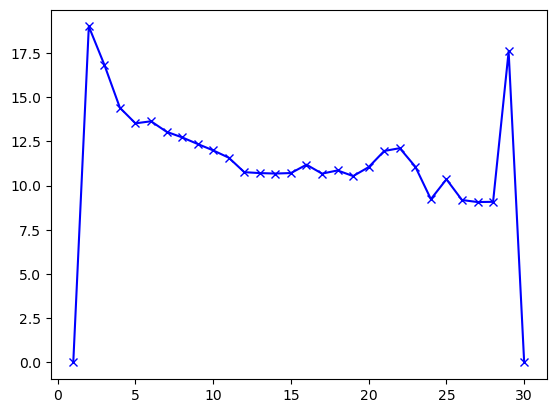

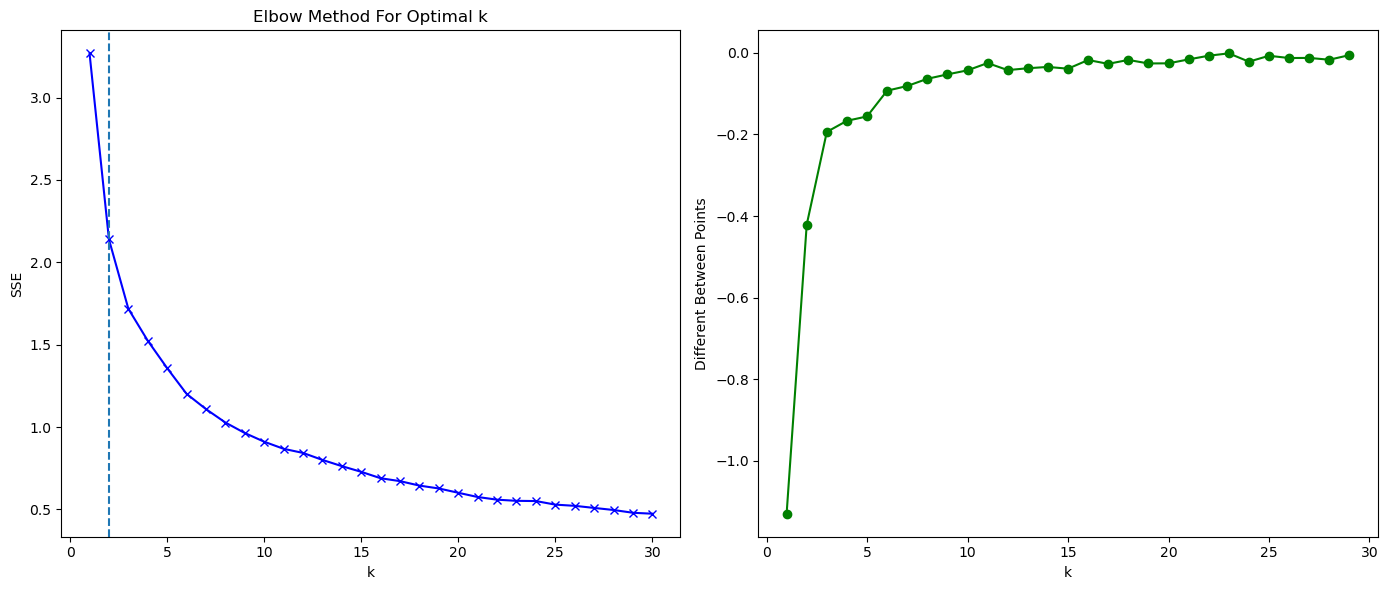

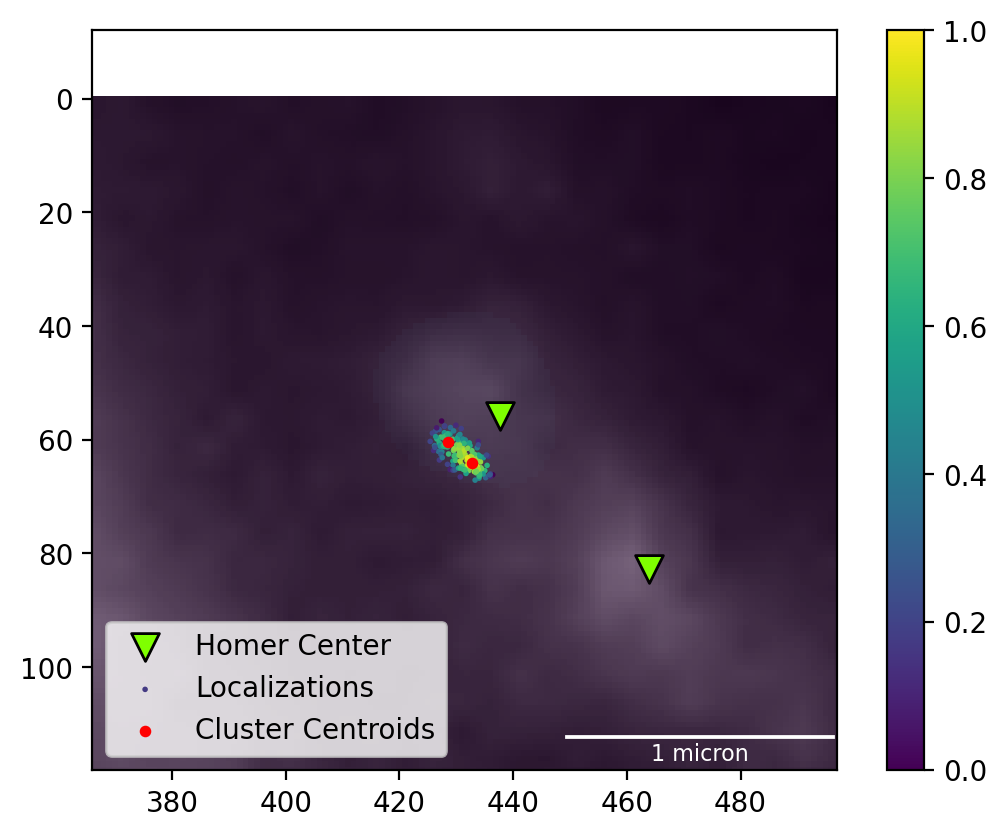

7.258503401360494
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


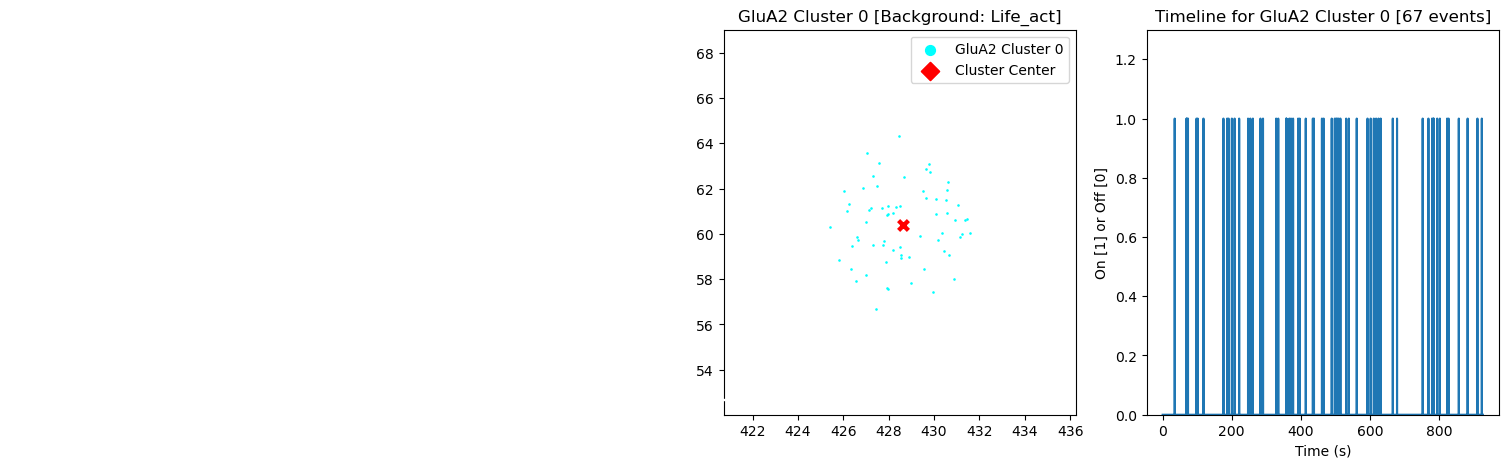

9.588683104192619
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


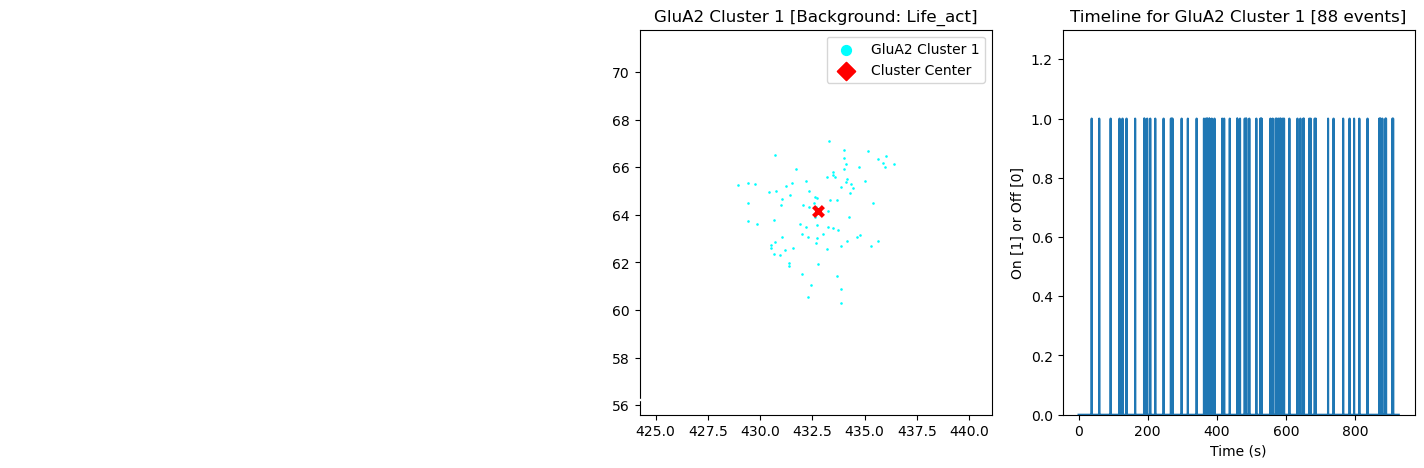

In [7]:
spine = FOV.Spines[2]
points_class = 'GluA1'
border = 50
xlim = (np.min(spine.roi[:, 0]) - border, np.max(spine.roi[:, 0]) + border)
ylim = (np.max(spine.roi[:, 1]) + border, np.min(spine.roi[:, 1]) - border)
n=30
k_max = 30
max_distance = 70/nm_per_pixel

# MMD Visualization
# points = points_in_area(GluA1, xlim, ylim)
points = spine.points['GluA2']
print(len(points))
kdtree = KDTree(points)
distances = np.array(kdtree.query(points, k=n, workers=-1)[0][:, -1])

points, distances = filter_by_nth_neighbor_distance(points, n, max_distance)
points, distances = filter_by_nth_neighbor_distance(points, n, max_distance)
print(len(points))
centroids, clusters = get_clusters_kmeans(points, k_max=k_max, to_plot=True)


plt.figure(dpi=200)
plt.imshow(LifeAct, cmap='gray')
plt.imshow(FOV.spinemap, alpha=0.3)
plt.xlim(*xlim)
plt.ylim(*ylim)
FOV.homer_centers.add_to_plot()
plt.scatter(points[:, 0], points[:, 1], c=distances, s=1, cmap='viridis_r', label="Localizations")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=10, label="Cluster Centroids")
plt.colorbar()
plt.legend(loc="lower left")
plot_scale_bar(nm_per_pixel)
plt.show()

for cluster in clusters:
    print(cluster.Tau_D/cluster.average_dark_time)
    cluster.plot()

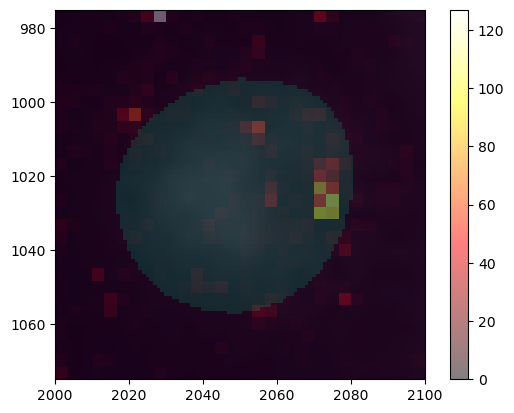

In [8]:
xlim = (2000, 2100)
ylim = (1075, 975)
points = GluA2
points = points_in_area(points, xlim, ylim)

heatmap, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=(30, 30))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# Plot the heatmap
plt.clf() # Clear current figure
plt.imshow(LifeAct, cmap='gray')
# plt.scatter(points[:, 0], points[:, 1], c='gray', s=0.50, cmap='viridis_r', label="Localizations", alpha=0.2)
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.5)
plt.colorbar() # Add a colorbar to a plot
plt.imshow(FOV.spinemap, alpha=0.3)

plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()